PARA BITCOIN Y ACCIONES RELACIONADAS




Obteniendo datos...
Descargando datos desde 2021-11-10 hasta 2024-11-09...
Obteniendo datos para BTC-USD...
Datos obtenidos exitosamente para BTC-USD: 1096 registros
Obteniendo datos para MSTR...
Datos obtenidos exitosamente para MSTR: 754 registros
Obteniendo datos para COIN...
Datos obtenidos exitosamente para COIN: 754 registros
Obteniendo datos para MARA...
Datos obtenidos exitosamente para MARA: 754 registros
Obteniendo datos para RIOT...
Datos obtenidos exitosamente para RIOT: 754 registros
Obteniendo datos para HIVE...
Datos obtenidos exitosamente para HIVE: 754 registros
Obteniendo datos para SQ...
Datos obtenidos exitosamente para SQ: 754 registros
Obteniendo datos para PYPL...
Datos obtenidos exitosamente para PYPL: 754 registros
Obteniendo datos para ARBK...
Datos obtenidos exitosamente para ARBK: 754 registros

Datos faltantes por símbolo:
BTC-USD     754
MSTR       1096
COIN       1096
MARA       1096
RIOT       1096
HIVE       1096
SQ         1096
PYPL       1096
ARBK    

<ipython-input-12-48d26544ce88>:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


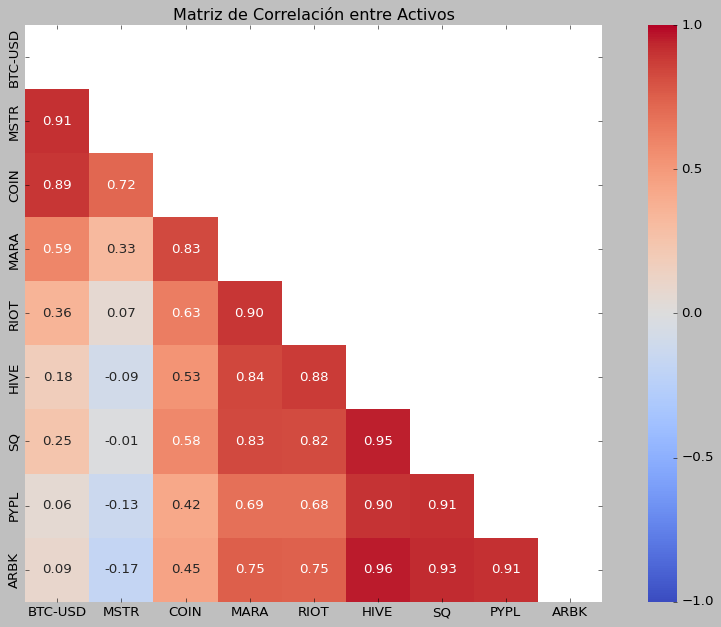

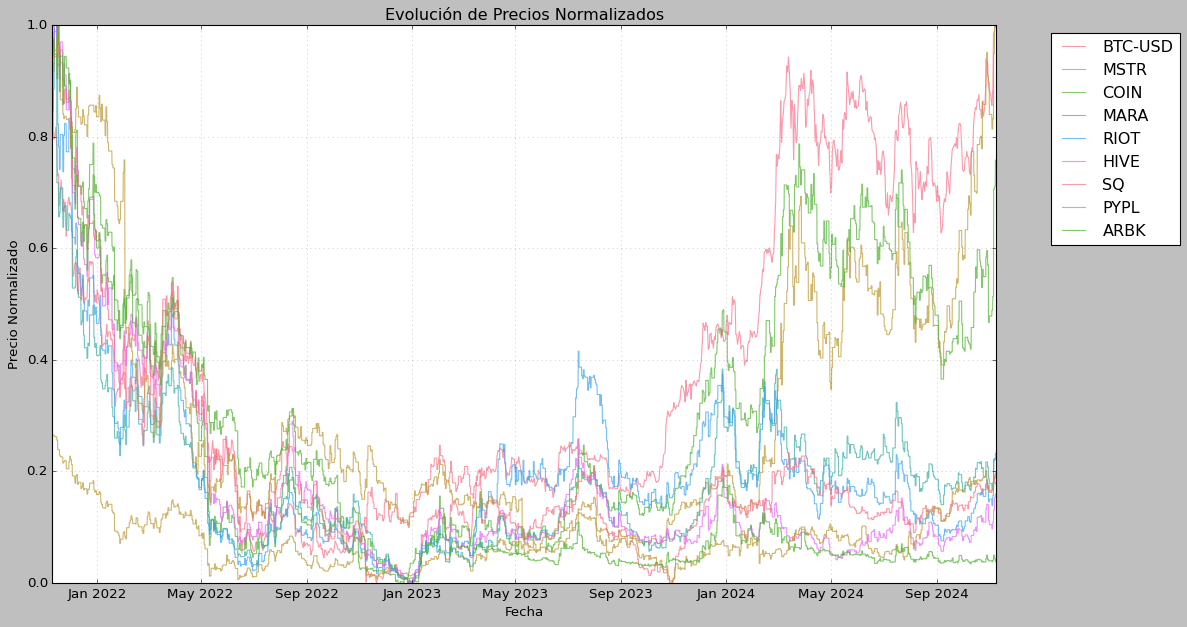

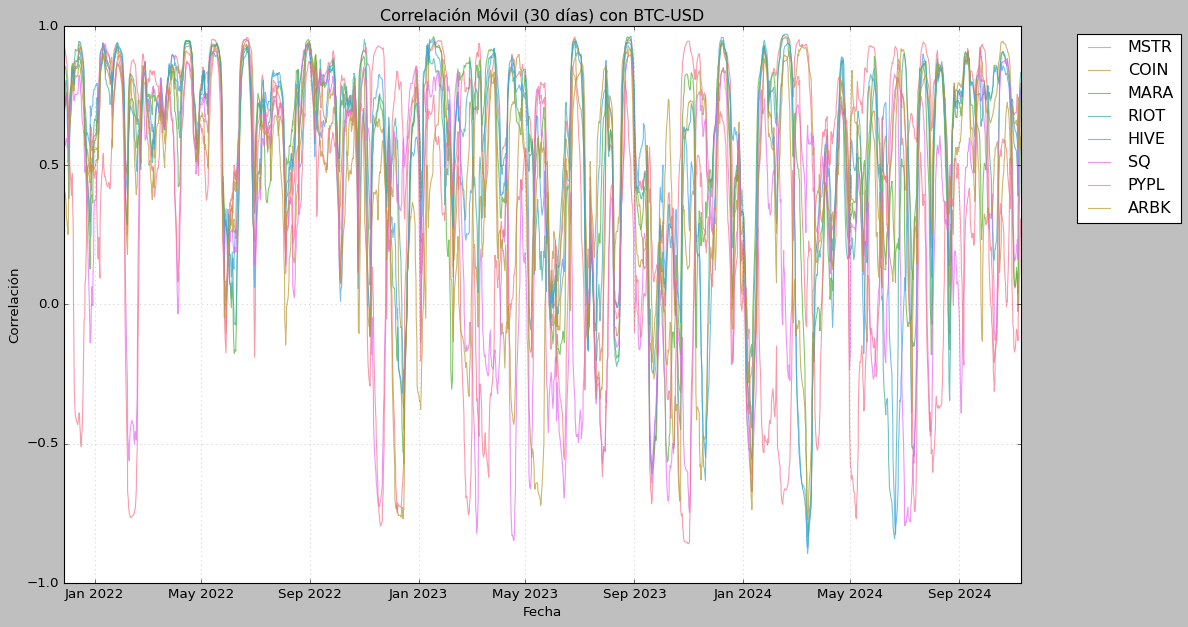


Preparando datos...

Entrenando modelos...

Analizando coeficientes...

Resultados del modelo:

Ridge:
MSE: 0.0347
R2 Score: 0.9642
CV Scores - Mean: -0.2150, Std: 0.2614

Lasso:
MSE: 0.0404
R2 Score: 0.9584
CV Scores - Mean: -0.1011, Std: 0.0640

ElasticNet:
MSE: 0.0384
R2 Score: 0.9604
CV Scores - Mean: -0.1329, Std: 0.1192

Importancia relativa de cada acción (%):
      Ridge_pct  Lasso_pct  ElasticNet_pct
MSTR      21.79      32.56           31.91
COIN      25.09      50.93           43.95
MARA       0.52       0.50            1.14
RIOT       8.15       2.18            2.37
HIVE      16.78       0.00            0.00
SQ         3.50       0.00            0.99
PYPL      10.70      13.83           16.26
ARBK      13.47       0.00            3.38

Generando visualizaciones de resultados...


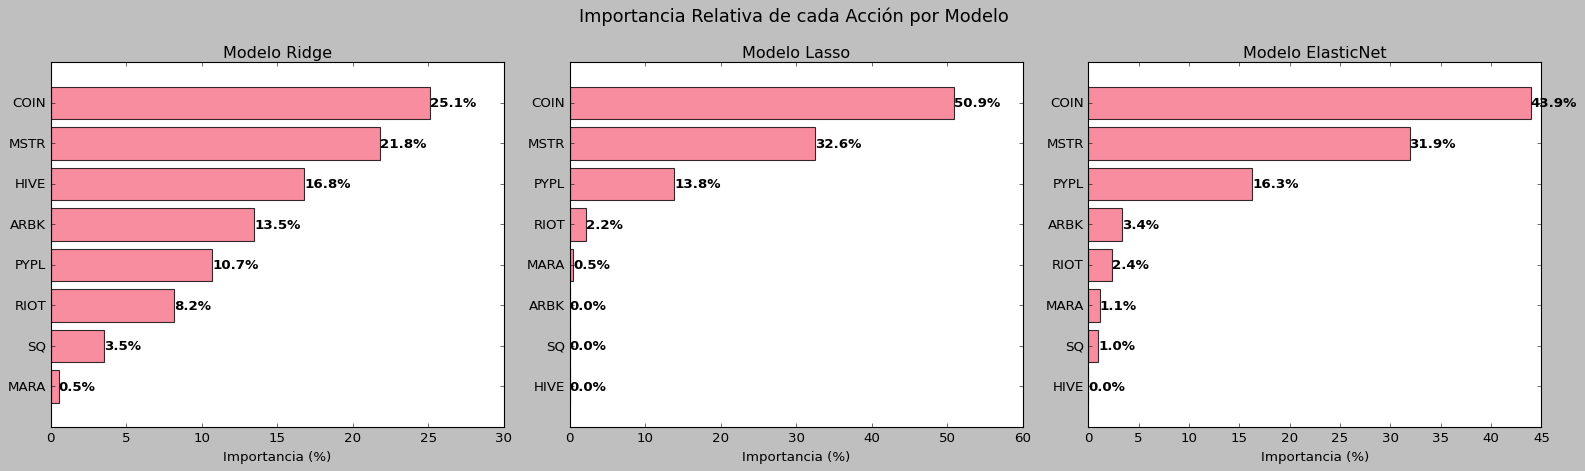

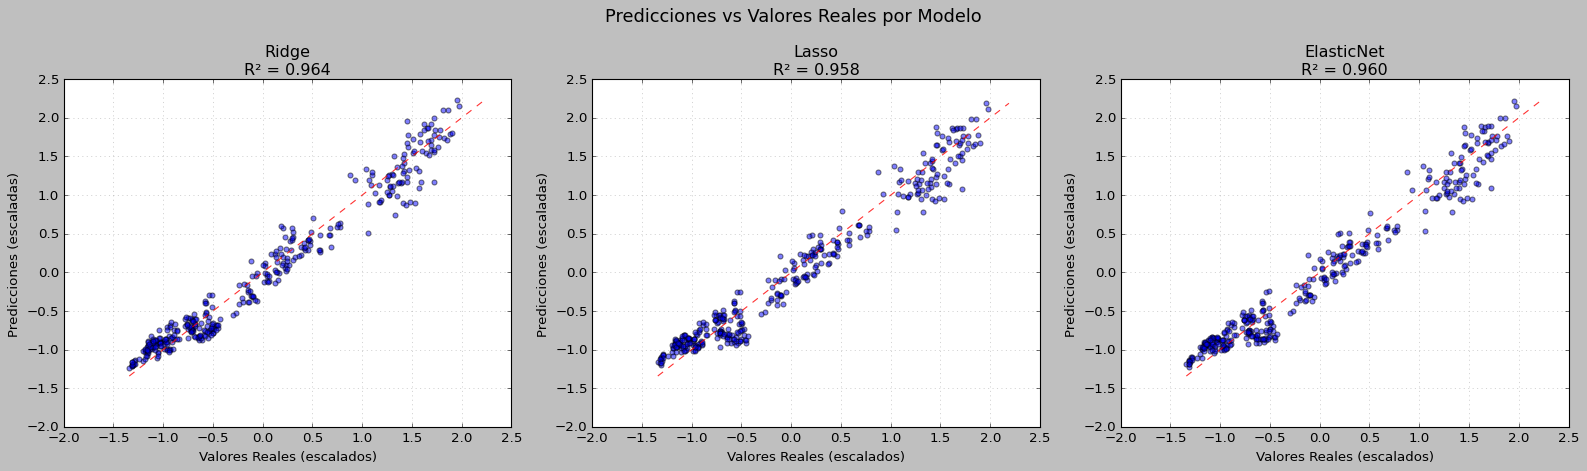

In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

def fetch_data():
    """
    Obtiene datos históricos de precios para los símbolos especificados.
    Incluye mejor manejo de errores y verificación de datos.
    """
    # Lista de símbolos a analizar
    symbols = ['BTC-USD', 'MSTR', 'COIN', 'MARA', 'RIOT', 'HIVE', 'SQ', 'PYPL', 'ARBK']

    # Calcular fechas
    end_date = datetime.now()
    start_date = end_date - timedelta(days=1095)  # Aproximadamente 3 años

    print(f"Descargando datos desde {start_date.date()} hasta {end_date.date()}...")

    # Descargar datos con mejor manejo de errores
    data_dict = {}
    failed_symbols = []

    for symbol in symbols:
        try:
            print(f"Obteniendo datos para {symbol}...")
            ticker = yf.Ticker(symbol)
            df = ticker.history(start=start_date, end=end_date)

            if df.empty:
                print(f"No se encontraron datos para {symbol}")
                failed_symbols.append(symbol)
                continue

            data_dict[symbol] = df['Close']
            print(f"Datos obtenidos exitosamente para {symbol}: {len(df)} registros")

        except Exception as e:
            print(f"Error al obtener datos para {symbol}: {str(e)}")
            failed_symbols.append(symbol)
            continue

    if not data_dict:
        raise ValueError("No se pudieron obtener datos para ningún símbolo")

    # Crear DataFrame
    df = pd.DataFrame(data_dict)

    # Verificar datos faltantes
    missing_data = df.isnull().sum()
    if missing_data.any():
        print("\nDatos faltantes por símbolo:")
        print(missing_data[missing_data > 0])

        # Llenar datos faltantes con el método forward fill seguido de backward fill
        df = df.fillna(method='ffill').fillna(method='bfill')
        print("Datos faltantes han sido interpolados")

    # Verificar que tenemos suficientes datos
    if len(df) < 30:  # Mínimo 30 días de trading
        raise ValueError(f"Insuficientes datos: solo {len(df)} días disponibles")

    # Imprimir información sobre el período de datos
    print(f"\nPeríodo de datos: {df.index[0]} hasta {df.index[-1]}")
    print(f"Número de días de trading: {len(df)}")
    print(f"\nAcciones incluidas en el análisis: {[s for s in symbols if s not in failed_symbols]}")

    # Si hay símbolos que fallaron, informar
    if failed_symbols:
        print(f"\nNo se pudieron obtener datos para: {failed_symbols}")

    # Imprimir correlaciones con BTC-USD si está presente
    if 'BTC-USD' in df.columns:
        print("\nCorrelaciones con BTC-USD:")
        print(df.corr()['BTC-USD'].sort_values(ascending=False))

    return df

def prepare_data(df):
    # Separar features (X) y target (y)
    X = df.drop('BTC-USD', axis=1)
    y = df['BTC-USD']
    feature_names = X.columns.tolist()

    # Escalar los datos
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

    return X_scaled, y_scaled, scaler_X, scaler_y, feature_names

def train_models(X_scaled, y_scaled):
    # Dividir datos en train y test
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )

    # Inicializar modelos
    models = {
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.01),
        'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5)
    }

    results = {}

    # Entrenar y evaluar cada modelo
    for name, model in models.items():
        # Entrenar modelo
        model.fit(X_train, y_train)

        # Hacer predicciones
        y_pred = model.predict(X_test)

        # Calcular métricas
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Realizar validación cruzada
        cv_scores = cross_val_score(
            model, X_scaled, y_scaled, cv=5, scoring='neg_mean_squared_error'
        )

        # Guardar resultados
        results[name] = {
            'model': model,
            'mse': mse,
            'r2': r2,
            'cv_scores': cv_scores,
            'test_predictions': y_pred,
            'test_actual': y_test
        }

    return results, X_train, X_test, y_train, y_test

def analyze_coefficients(results, feature_names):
    # Crear DataFrame para almacenar coeficientes
    coef_df = pd.DataFrame(index=feature_names)

    # Para cada modelo
    for name, metrics in results.items():
        model = metrics['model']
        coefficients = np.abs(model.coef_)

        # Calcular porcentajes
        percentages = (coefficients / coefficients.sum()) * 100

        # Agregar al DataFrame
        coef_df[f'{name}_coef'] = coefficients
        coef_df[f'{name}_pct'] = percentages

    return coef_df


def set_style():
    # Configurar el estilo de las visualizaciones
    plt.style.use('classic')
    sns.set_palette("husl")
    plt.rcParams['figure.figsize'] = [12, 7]
    plt.rcParams['font.size'] = 12

def plot_correlation_heatmap(df):
    plt.figure(figsize=(12, 8))
    correlation_matrix = df.corr()

    # Crear máscara para el triángulo superior
    mask = np.zeros_like(correlation_matrix)
    mask[np.triu_indices_from(mask)] = True

    # Crear heatmap
    sns.heatmap(correlation_matrix,
                mask=mask,
                annot=True,
                fmt='.2f',
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True)

    plt.title('Matriz de Correlación entre Activos')
    plt.tight_layout()
    plt.show()

def plot_normalized_prices(df):
    # Normalizar precios al rango [0,1] para mejor comparación
    normalized_df = (df - df.min()) / (df.max() - df.min())

    plt.figure(figsize=(15, 8))
    for column in normalized_df.columns:
        plt.plot(normalized_df.index, normalized_df[column], label=column, alpha=0.7)

    plt.title('Evolución de Precios Normalizados')
    plt.xlabel('Fecha')
    plt.ylabel('Precio Normalizado')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_importance_comparison(coef_df):
    # Obtener solo las columnas de porcentajes
    pct_cols = [col for col in coef_df.columns if 'pct' in col]
    importance_df = coef_df[pct_cols]

    # Crear figura con subplots para cada modelo
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Importancia Relativa de cada Acción por Modelo', fontsize=16)

    for i, col in enumerate(pct_cols):
        model_name = col.replace('_pct', '')

        # Ordenar valores por importancia
        sorted_importance = importance_df[col].sort_values(ascending=True)

        # Crear barras horizontales
        bars = axes[i].barh(range(len(sorted_importance)),
                          sorted_importance,
                          alpha=0.8)

        # Añadir etiquetas
        axes[i].set_yticks(range(len(sorted_importance)))
        axes[i].set_yticklabels(sorted_importance.index)
        axes[i].set_title(f'Modelo {model_name}')
        axes[i].set_xlabel('Importancia (%)')

        # Añadir valores en las barras
        for bar in bars:
            width = bar.get_width()
            axes[i].text(width,
                        bar.get_y() + bar.get_height()/2,
                        f'{width:.1f}%',
                        ha='left',
                        va='center',
                        fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actual(results):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Predicciones vs Valores Reales por Modelo', fontsize=16)

    for i, (name, metrics) in enumerate(results.items()):
        y_test = metrics['test_actual']
        y_pred = metrics['test_predictions']

        # Crear scatter plot
        axes[i].scatter(y_test, y_pred, alpha=0.5)

        # Añadir línea de referencia perfecta
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)

        axes[i].set_title(f'{name}\nR² = {metrics["r2"]:.3f}')
        axes[i].set_xlabel('Valores Reales (escalados)')
        axes[i].set_ylabel('Predicciones (escaladas)')
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def calculate_rolling_correlation(df, window=30):
    # Calcular correlaciones móviles con BTC-USD
    rolling_corr = pd.DataFrame()
    for column in df.columns:
        if column != 'BTC-USD':
            rolling_corr[column] = df['BTC-USD'].rolling(window).corr(df[column])

    # Plotear correlaciones móviles
    plt.figure(figsize=(15, 8))
    for column in rolling_corr.columns:
        plt.plot(rolling_corr.index, rolling_corr[column], label=column, alpha=0.7)

    plt.title(f'Correlación Móvil ({window} días) con BTC-USD')
    plt.xlabel('Fecha')
    plt.ylabel('Correlación')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def main():
    try:
        # Configurar estilo
        set_style()

        # Obtener datos
        print("Obteniendo datos...")
        df = fetch_data()

        if df.empty:
            print("No se pudieron obtener datos. Terminando ejecución.")
            return

        # Visualizaciones iniciales
        print("\nGenerando visualizaciones de datos...")
        plot_correlation_heatmap(df)
        plot_normalized_prices(df)
        calculate_rolling_correlation(df)

        # Preparar datos
        print("\nPreparando datos...")
        X_scaled, y_scaled, scaler_X, scaler_y, feature_names = prepare_data(df)

        # Entrenar modelos
        print("\nEntrenando modelos...")
        results, X_train, X_test, y_train, y_test = train_models(X_scaled, y_scaled)

        # Analizar coeficientes
        print("\nAnalizando coeficientes...")
        coef_df = analyze_coefficients(results, feature_names)

        # Mostrar resultados
        print("\nResultados del modelo:")
        for name, metrics in results.items():
            print(f"\n{name}:")
            print(f"MSE: {metrics['mse']:.4f}")
            print(f"R2 Score: {metrics['r2']:.4f}")
            print(f"CV Scores - Mean: {metrics['cv_scores'].mean():.4f}, Std: {metrics['cv_scores'].std():.4f}")

        # Mostrar importancia relativa
        print("\nImportancia relativa de cada acción (%):")
        importance_cols = [col for col in coef_df.columns if 'pct' in col]
        print(coef_df[importance_cols].round(2))

        # Visualizaciones de resultados
        print("\nGenerando visualizaciones de resultados...")
        plot_importance_comparison(coef_df)
        plot_predictions_vs_actual(results)

    except Exception as e:
        print(f"\nError durante la ejecución: {str(e)}")
        import traceback
        print("\nDetalles del error:")
        print(traceback.format_exc())

if __name__ == "__main__":
    main()

URANIO Y ACCIONES RELACIONADAS


Obteniendo datos...
Descargando datos desde 2021-11-10 hasta 2024-11-09...
Obteniendo datos para URA...
Datos obtenidos exitosamente para URA: 754 registros
Obteniendo datos para CCJ...
Datos obtenidos exitosamente para CCJ: 754 registros
Obteniendo datos para KAP...


ERROR:yfinance:$KAP: possibly delisted; no price data found  (1d 2021-11-10 13:03:31.342929 -> 2024-11-09 13:03:31.342929)


No se encontraron datos para KAP
Obteniendo datos para DNN ...


ERROR:yfinance:$DNN : possibly delisted; no timezone found


No se encontraron datos para DNN 
Obteniendo datos para UEC...
Datos obtenidos exitosamente para UEC: 754 registros
Obteniendo datos para UUUU...
Datos obtenidos exitosamente para UUUU: 754 registros
Obteniendo datos para NXE...
Datos obtenidos exitosamente para NXE: 754 registros
Obteniendo datos para DML...


ERROR:yfinance:$DML: possibly delisted; no price data found  (1d 2021-11-10 13:03:31.342929 -> 2024-11-09 13:03:31.342929)


No se encontraron datos para DML
Obteniendo datos para LTBR...
Datos obtenidos exitosamente para LTBR: 754 registros

Período de datos: 2021-11-10 00:00:00-05:00 hasta 2024-11-08 00:00:00-05:00
Número de días de trading: 754

Acciones incluidas en el análisis: ['URA', 'CCJ', 'UEC', 'UUUU', 'NXE', 'LTBR']

No se pudieron obtener datos para: ['KAP', 'DNN ', 'DML']

Correlaciones con URA:
URA     1.000000
NXE     0.977020
UEC     0.953688
CCJ     0.929745
UUUU    0.124769
LTBR   -0.281873
Name: URA, dtype: float64

Generando visualizaciones de datos...


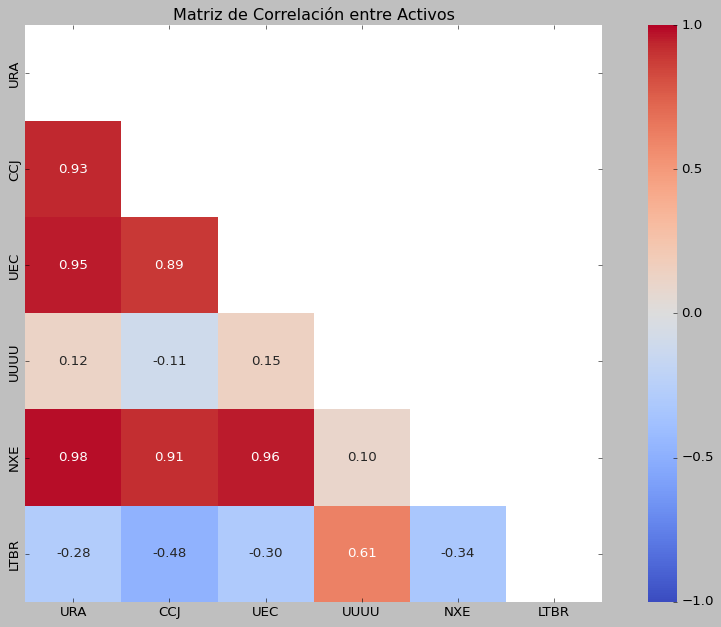

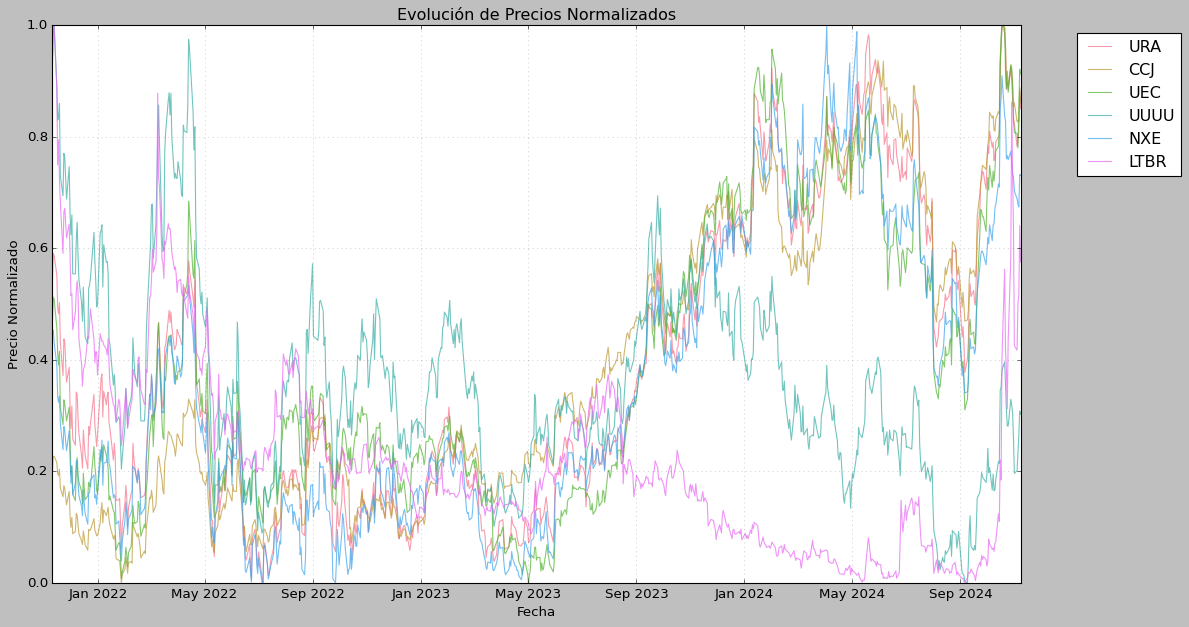

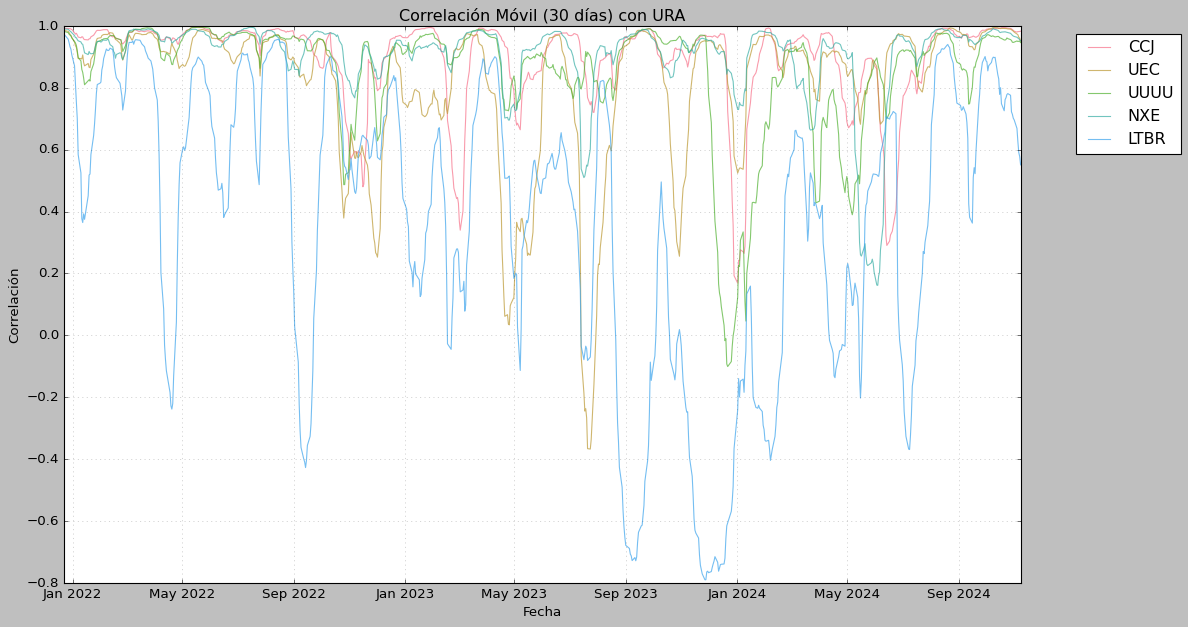


Preparando datos...

Entrenando modelos...

Analizando coeficientes...

Resultados del modelo:

Ridge:
MSE: 0.0286
R2 Score: 0.9736
CV Scores - Mean: -0.1302, Std: 0.1063

Lasso:
MSE: 0.0286
R2 Score: 0.9736
CV Scores - Mean: -0.1287, Std: 0.0968

ElasticNet:
MSE: 0.0282
R2 Score: 0.9740
CV Scores - Mean: -0.1270, Std: 0.0963

Importancia relativa de cada acción (%):
      Ridge_pct  Lasso_pct  ElasticNet_pct
CCJ       29.57      28.03           29.10
UEC       10.21      10.41           12.01
UUUU       1.76       1.62            1.78
NXE       49.44      52.31           48.95
LTBR       9.02       7.64            8.17

Generando visualizaciones de resultados...


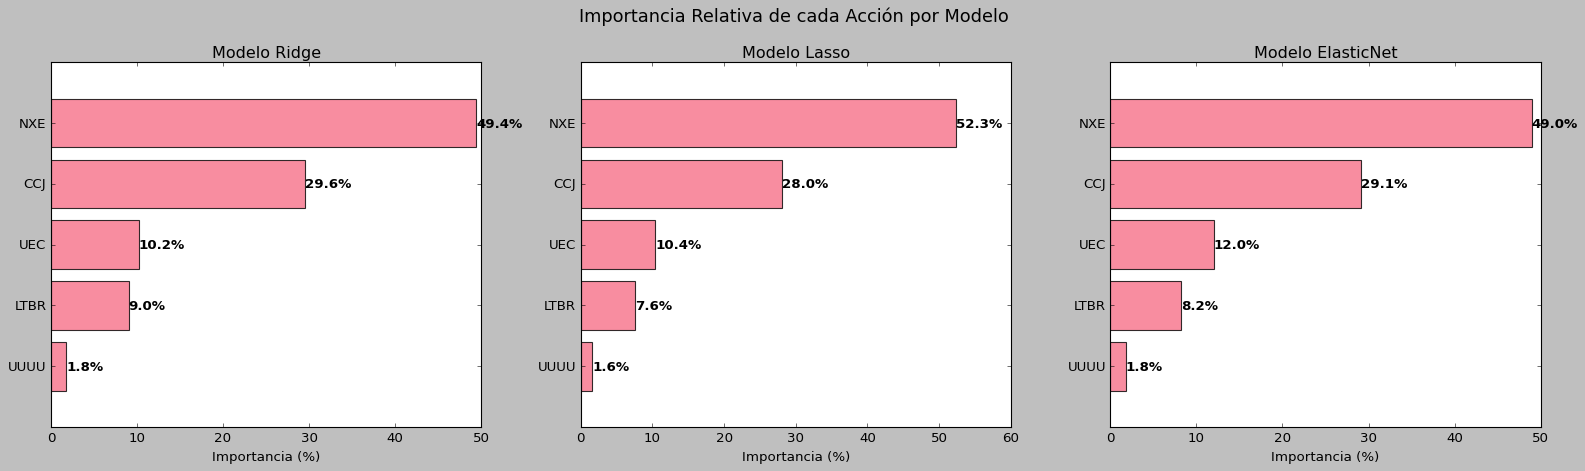

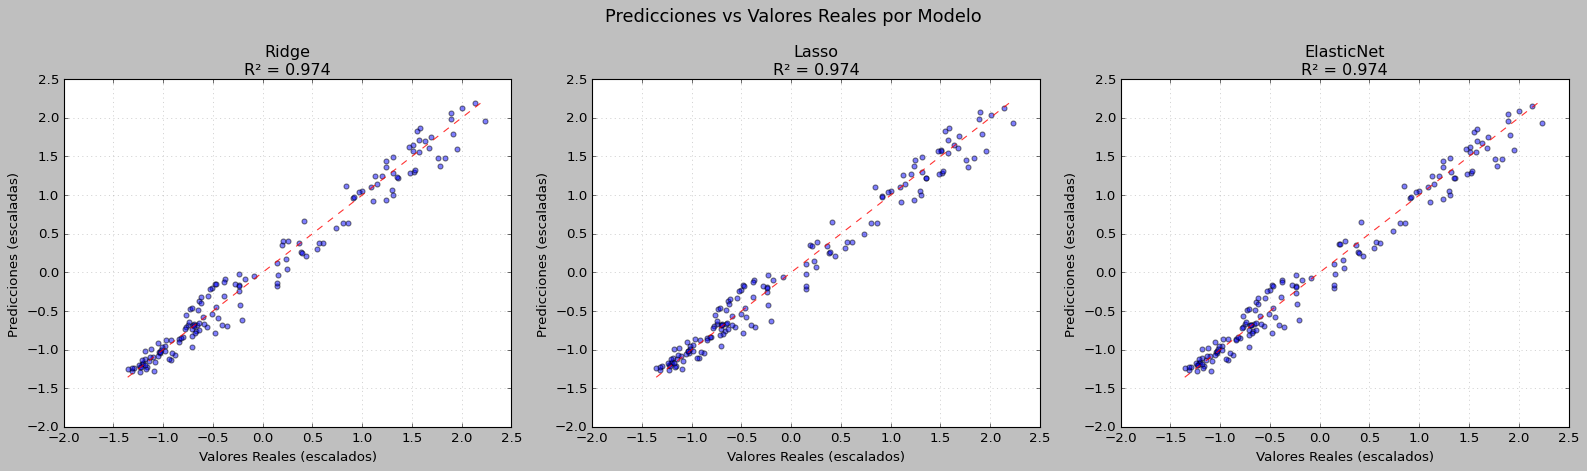

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

def fetch_data():
    """
    Obtiene datos históricos de precios para los símbolos especificados.
    Incluye mejor manejo de errores y verificación de datos.
    """
    # Lista de símbolos a analizar
    symbols = ['URA', 'CCJ', 'KAP', 'DNN ', 'UEC', 'UUUU', 'NXE', 'DML', 'LTBR']

    # Calcular fechas
    end_date = datetime.now()
    start_date = end_date - timedelta(days=3*365)  # Aproximadamente 3 años

    print(f"Descargando datos desde {start_date.date()} hasta {end_date.date()}...")

    # Descargar datos con mejor manejo de errores
    data_dict = {}
    failed_symbols = []

    for symbol in symbols:
        try:
            print(f"Obteniendo datos para {symbol}...")
            ticker = yf.Ticker(symbol)
            df = ticker.history(start=start_date, end=end_date)

            if df.empty:
                print(f"No se encontraron datos para {symbol}")
                failed_symbols.append(symbol)
                continue

            data_dict[symbol] = df['Close']
            print(f"Datos obtenidos exitosamente para {symbol}: {len(df)} registros")

        except Exception as e:
            print(f"Error al obtener datos para {symbol}: {str(e)}")
            failed_symbols.append(symbol)
            continue

    if not data_dict:
        raise ValueError("No se pudieron obtener datos para ningún símbolo")

    # Crear DataFrame
    df = pd.DataFrame(data_dict)

    # Verificar datos faltantes
    missing_data = df.isnull().sum()
    if missing_data.any():
        print("\nDatos faltantes por símbolo:")
        print(missing_data[missing_data > 0])

        # Llenar datos faltantes con el método forward fill seguido de backward fill
        df = df.fillna(method='ffill').fillna(method='bfill')
        print("Datos faltantes han sido interpolados")

    # Verificar que tenemos suficientes datos
    if len(df) < 30:  # Mínimo 30 días de trading
        raise ValueError(f"Insuficientes datos: solo {len(df)} días disponibles")

    # Imprimir información sobre el período de datos
    print(f"\nPeríodo de datos: {df.index[0]} hasta {df.index[-1]}")
    print(f"Número de días de trading: {len(df)}")
    print(f"\nAcciones incluidas en el análisis: {[s for s in symbols if s not in failed_symbols]}")

    # Si hay símbolos que fallaron, informar
    if failed_symbols:
        print(f"\nNo se pudieron obtener datos para: {failed_symbols}")

    # Imprimir correlaciones con URA si está presente
    if 'URA' in df.columns:
        print("\nCorrelaciones con URA:")
        print(df.corr()['URA'].sort_values(ascending=False))

    return df

def prepare_data(df):
    # Separar features (X) y target (y)
    X = df.drop('URA', axis=1)
    y = df['URA']
    feature_names = X.columns.tolist()

    # Escalar los datos
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

    return X_scaled, y_scaled, scaler_X, scaler_y, feature_names

def train_models(X_scaled, y_scaled):
    # Dividir datos en train y test
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )

    # Inicializar modelos
    models = {
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.01),
        'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5)
    }

    results = {}

    # Entrenar y evaluar cada modelo
    for name, model in models.items():
        # Entrenar modelo
        model.fit(X_train, y_train)

        # Hacer predicciones
        y_pred = model.predict(X_test)

        # Calcular métricas
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Realizar validación cruzada
        cv_scores = cross_val_score(
            model, X_scaled, y_scaled, cv=5, scoring='neg_mean_squared_error'
        )

        # Guardar resultados
        results[name] = {
            'model': model,
            'mse': mse,
            'r2': r2,
            'cv_scores': cv_scores,
            'test_predictions': y_pred,
            'test_actual': y_test
        }

    return results, X_train, X_test, y_train, y_test

def analyze_coefficients(results, feature_names):
    # Crear DataFrame para almacenar coeficientes
    coef_df = pd.DataFrame(index=feature_names)

    # Para cada modelo
    for name, metrics in results.items():
        model = metrics['model']
        coefficients = np.abs(model.coef_)

        # Calcular porcentajes
        percentages = (coefficients / coefficients.sum()) * 100

        # Agregar al DataFrame
        coef_df[f'{name}_coef'] = coefficients
        coef_df[f'{name}_pct'] = percentages

    return coef_df


def set_style():
    # Configurar el estilo de las visualizaciones
    plt.style.use('classic')
    sns.set_palette("husl")
    plt.rcParams['figure.figsize'] = [12, 7]
    plt.rcParams['font.size'] = 12

def plot_correlation_heatmap(df):
    plt.figure(figsize=(12, 8))
    correlation_matrix = df.corr()

    # Crear máscara para el triángulo superior
    mask = np.zeros_like(correlation_matrix)
    mask[np.triu_indices_from(mask)] = True

    # Crear heatmap
    sns.heatmap(correlation_matrix,
                mask=mask,
                annot=True,
                fmt='.2f',
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True)

    plt.title('Matriz de Correlación entre Activos')
    plt.tight_layout()
    plt.show()

def plot_normalized_prices(df):
    # Normalizar precios al rango [0,1] para mejor comparación
    normalized_df = (df - df.min()) / (df.max() - df.min())

    plt.figure(figsize=(15, 8))
    for column in normalized_df.columns:
        plt.plot(normalized_df.index, normalized_df[column], label=column, alpha=0.7)

    plt.title('Evolución de Precios Normalizados')
    plt.xlabel('Fecha')
    plt.ylabel('Precio Normalizado')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_importance_comparison(coef_df):
    # Obtener solo las columnas de porcentajes
    pct_cols = [col for col in coef_df.columns if 'pct' in col]
    importance_df = coef_df[pct_cols]

    # Crear figura con subplots para cada modelo
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Importancia Relativa de cada Acción por Modelo', fontsize=16)

    for i, col in enumerate(pct_cols):
        model_name = col.replace('_pct', '')

        # Ordenar valores por importancia
        sorted_importance = importance_df[col].sort_values(ascending=True)

        # Crear barras horizontales
        bars = axes[i].barh(range(len(sorted_importance)),
                          sorted_importance,
                          alpha=0.8)

        # Añadir etiquetas
        axes[i].set_yticks(range(len(sorted_importance)))
        axes[i].set_yticklabels(sorted_importance.index)
        axes[i].set_title(f'Modelo {model_name}')
        axes[i].set_xlabel('Importancia (%)')

        # Añadir valores en las barras
        for bar in bars:
            width = bar.get_width()
            axes[i].text(width,
                        bar.get_y() + bar.get_height()/2,
                        f'{width:.1f}%',
                        ha='left',
                        va='center',
                        fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actual(results):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Predicciones vs Valores Reales por Modelo', fontsize=16)

    for i, (name, metrics) in enumerate(results.items()):
        y_test = metrics['test_actual']
        y_pred = metrics['test_predictions']

        # Crear scatter plot
        axes[i].scatter(y_test, y_pred, alpha=0.5)

        # Añadir línea de referencia perfecta
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)

        axes[i].set_title(f'{name}\nR² = {metrics["r2"]:.3f}')
        axes[i].set_xlabel('Valores Reales (escalados)')
        axes[i].set_ylabel('Predicciones (escaladas)')
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def calculate_rolling_correlation(df, window=30):
    # Calcular correlaciones móviles con URA
    rolling_corr = pd.DataFrame()
    for column in df.columns:
        if column != 'URA':
            rolling_corr[column] = df['URA'].rolling(window).corr(df[column])

    # Plotear correlaciones móviles
    plt.figure(figsize=(15, 8))
    for column in rolling_corr.columns:
        plt.plot(rolling_corr.index, rolling_corr[column], label=column, alpha=0.7)

    plt.title(f'Correlación Móvil ({window} días) con URA')
    plt.xlabel('Fecha')
    plt.ylabel('Correlación')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def main():
    try:
        # Configurar estilo
        set_style()

        # Obtener datos
        print("Obteniendo datos...")
        df = fetch_data()

        if df.empty:
            print("No se pudieron obtener datos. Terminando ejecución.")
            return

        # Visualizaciones iniciales
        print("\nGenerando visualizaciones de datos...")
        plot_correlation_heatmap(df)
        plot_normalized_prices(df)
        calculate_rolling_correlation(df)

        # Preparar datos
        print("\nPreparando datos...")
        X_scaled, y_scaled, scaler_X, scaler_y, feature_names = prepare_data(df)

        # Entrenar modelos
        print("\nEntrenando modelos...")
        results, X_train, X_test, y_train, y_test = train_models(X_scaled, y_scaled)

        # Analizar coeficientes
        print("\nAnalizando coeficientes...")
        coef_df = analyze_coefficients(results, feature_names)

        # Mostrar resultados
        print("\nResultados del modelo:")
        for name, metrics in results.items():
            print(f"\n{name}:")
            print(f"MSE: {metrics['mse']:.4f}")
            print(f"R2 Score: {metrics['r2']:.4f}")
            print(f"CV Scores - Mean: {metrics['cv_scores'].mean():.4f}, Std: {metrics['cv_scores'].std():.4f}")

        # Mostrar importancia relativa
        print("\nImportancia relativa de cada acción (%):")
        importance_cols = [col for col in coef_df.columns if 'pct' in col]
        print(coef_df[importance_cols].round(2))

        # Visualizaciones de resultados
        print("\nGenerando visualizaciones de resultados...")
        plot_importance_comparison(coef_df)
        plot_predictions_vs_actual(results)

    except Exception as e:
        print(f"\nError durante la ejecución: {str(e)}")
        import traceback
        print("\nDetalles del error:")
        print(traceback.format_exc())

if __name__ == "__main__":
    main()